#**Probability of Default (PD) Modelling**

###By **Milan Sharma**

##**Import Libraries**

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
from numpy.random import seed
seed(0)
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.impute import KNNImputer
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [5]:
import xgboost as xgb

##**Read Data**

In [7]:
#Paths to Dataset files.

financial_data_path = '/DATA_dr/financial_data.csv'
default_data_path = '/DATA_dr/default_data.csv'

In [8]:
#Read 'financial.csv' file.

df_financial = pd.read_csv(financial_data_path)
df_financial.head()

LOAN_ID  PD_RISK_RATING                X1        X2  ...       X12  X13   X14  X15
0  ZZZ0001               2               C&I  0.113703  ...  0.890361    C  T982  Yes
1  ZZZ0002               4     CRE Permanent  0.622299  ...  0.857632    B  X456  Yes
2  ZZZ0003               2  CRE Construction  0.609275  ...  0.150828    B  T982  Yes
3  ZZZ0004               1  CRE Construction  0.623379  ...  0.120293    B  T982   No
4  ZZZ0005               2  CRE Construction  0.860915  ...  0.329663    B  R567  Yes

[5 rows x 17 columns]

In [9]:
#Read 'default.csv' file.

df_default = pd.read_csv(default_data_path)
df_default.head()

Unnamed: 0    LOAN_ID
0           1   ZZZ00085
1           2  ZZZ000101
2           3  ZZZ000108
3           4  ZZZ000119
4           5  ZZZ000258

In [10]:
#Get information about various coulmns in the 'financial' dataframe.

df_financial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LOAN_ID         10000 non-null  object 
 1   PD_RISK_RATING  10000 non-null  int64  
 2   X1              10000 non-null  object 
 3   X2              9000 non-null   float64
 4   X3              10000 non-null  float64
 5   X4              9000 non-null   float64
 6   X5              10000 non-null  float64
 7   X6              10000 non-null  float64
 8   X7              10000 non-null  float64
 9   X8              10000 non-null  float64
 10  X9              10000 non-null  float64
 11  X10             10000 non-null  float64
 12  X11             10000 non-null  float64
 13  X12             10000 non-null  float64
 14  X13             10000 non-null  object 
 15  X14             10000 non-null  object 
 16  X15             10000 non-null  object 
dtypes: float64(11), int64(1), object

In [11]:
#Get information about various coulmns in the 'default' dataframe.

df_default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  129 non-null    int64 
 1   LOAN_ID     129 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [12]:
#Drop column that is not required from the financial dataframe.

df_financial = df_financial.drop(['PD_RISK_RATING'], axis=1)
df_financial.head()

LOAN_ID                X1        X2        X3  ...       X12  X13   X14  X15
0  ZZZ0001               C&I  0.113703  0.795355  ...  0.890361    C  T982  Yes
1  ZZZ0002     CRE Permanent  0.622299  0.364232  ...  0.857632    B  X456  Yes
2  ZZZ0003  CRE Construction  0.609275  0.821238  ...  0.150828    B  T982  Yes
3  ZZZ0004  CRE Construction  0.623379  0.613073  ...  0.120293    B  T982   No
4  ZZZ0005  CRE Construction  0.860915  0.709228  ...  0.329663    B  R567  Yes

[5 rows x 16 columns]

In [13]:
#Drop column that is not required from the financial dataframe.

df_default = df_default.drop(df_default.columns[0], axis=1)
df_default.head()

LOAN_ID
0   ZZZ00085
1  ZZZ000101
2  ZZZ000108
3  ZZZ000119
4  ZZZ000258

##**Join Features with Labels**

In [14]:
#Function to print class distribution of the input dataframe.
#Args: DataFrame, Class column name.

def get_class_distribution(df, class_col='Default_Ind'):
  class_dist = df[class_col].value_counts()
  print('Class 0: {} | {:.3f}%'.format(class_dist[0], (class_dist[0]/class_dist.sum())*100))
  print('Class 1: {} | {:.3f}%'.format(class_dist[1], (class_dist[1]/class_dist.sum())*100))

In [15]:
#Joining 'financial' dataframe with 'default' dataframe and creating class labels ('0': Non Default, '1': Default).

df_default_ind = (df_financial.LOAN_ID.isin(df_default.LOAN_ID)).astype(int)

In [16]:
#Dropping 'LOAN_ID' and adding 'Default_Ind' column created in the previous step.

df_data = df_financial.drop(['LOAN_ID'], axis=1)
df_data['Default_Ind']=df_default_ind
df_data.head()

X1        X2        X3  ...   X14  X15  Default_Ind
0               C&I  0.113703  0.795355  ...  T982  Yes            0
1     CRE Permanent  0.622299  0.364232  ...  X456  Yes            0
2  CRE Construction  0.609275  0.821238  ...  T982  Yes            0
3  CRE Construction  0.623379  0.613073  ...  T982   No            0
4  CRE Construction  0.860915  0.709228  ...  R567  Yes            0

[5 rows x 16 columns]

In [17]:
#Class distribution of the dataset.

print('Class Distribution')
get_class_distribution(df_data)

Class Distribution
Class 0: 9871 | 98.710%
Class 1: 129 | 1.290%


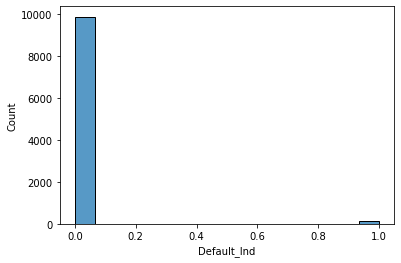

In [18]:
#Visualizing class distribution.
sns.histplot(df_data['Default_Ind'])
plt.show()

##**Train-Test dataset split**

In [19]:
#Splitting the entire dataset (10000 rows) into Train and Test Sets.
#First 7000 rows for Train set.
#Last 3000 rows for Test set.

df_train_data = df_data.iloc[:7000,:]
df_test_data = df_data.iloc[7000:,:]

In [20]:
#Resetting the row indices of new created Train and Test Sets.

df_train_data.reset_index(drop=True, inplace=True)
df_test_data.reset_index(drop=True, inplace=True)

In [21]:
#Class Distribution of Train Set.

print('Training Data')
get_class_distribution(df_train_data)

Training Data
Class 0: 6910 | 98.714%
Class 1: 90 | 1.286%


In [22]:
#Class Distribution of Test Set.

print('Testing Data')
get_class_distribution(df_test_data)

Testing Data
Class 0: 2961 | 98.700%
Class 1: 39 | 1.300%


##**Visualizing Training Data and EDA**



###1. Univariate Analysis

In [23]:
#Calculating various statistical metrics for numerical features (individually for each class label '0' and '1').

df_train_data.groupby(by='Default_Ind').describe()

X2                      ...       X12                    
              count      mean       std  ...       50%       75%       max
Default_Ind                              ...                              
0            6235.0  0.507968  0.286371  ...  0.496587  0.756503  0.999704
1              77.0  0.103668  0.150504  ...  0.479001  0.754275  0.965411

[2 rows x 88 columns]

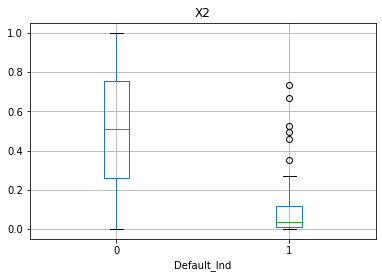

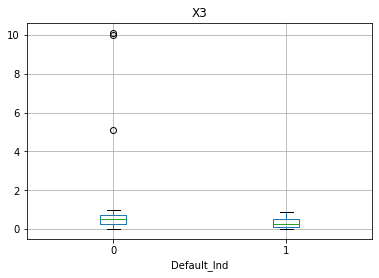

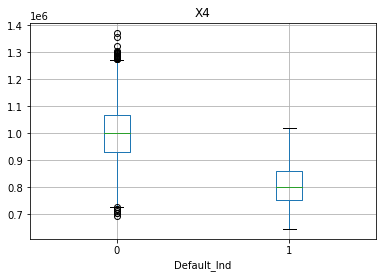

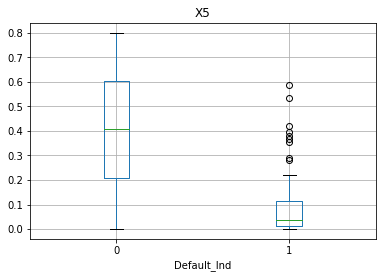

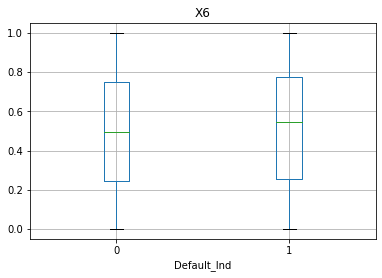

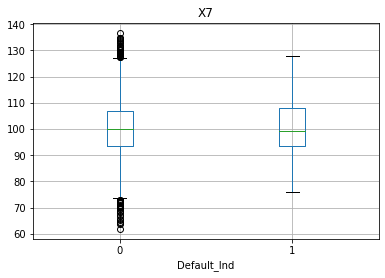

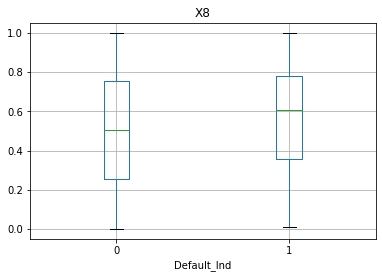

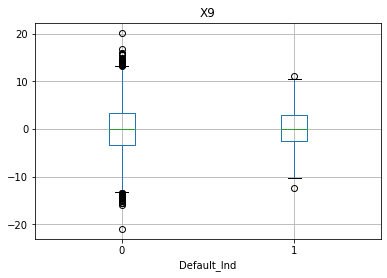

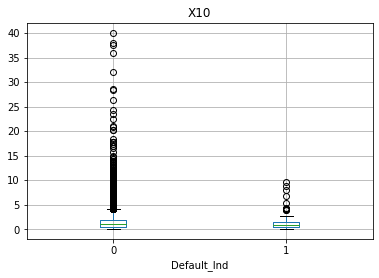

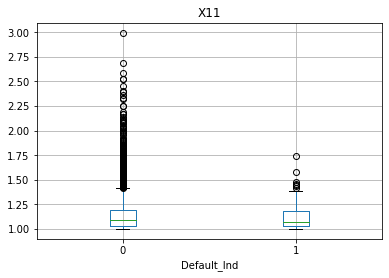

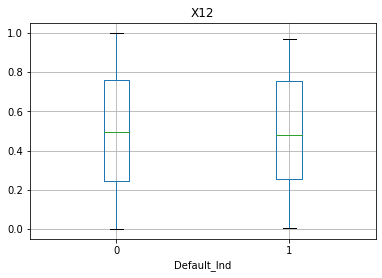

In [24]:
#Creating Box-plots for all the numeric features grouped by class labels.

num_columns = df_train_data.columns[1:12]
for column in num_columns:
  box_plots = df_train_data.boxplot(column=[column], by='Default_Ind')
  fig = np.asarray(box_plots).reshape(-1)[0].get_figure()
  fig.suptitle("")

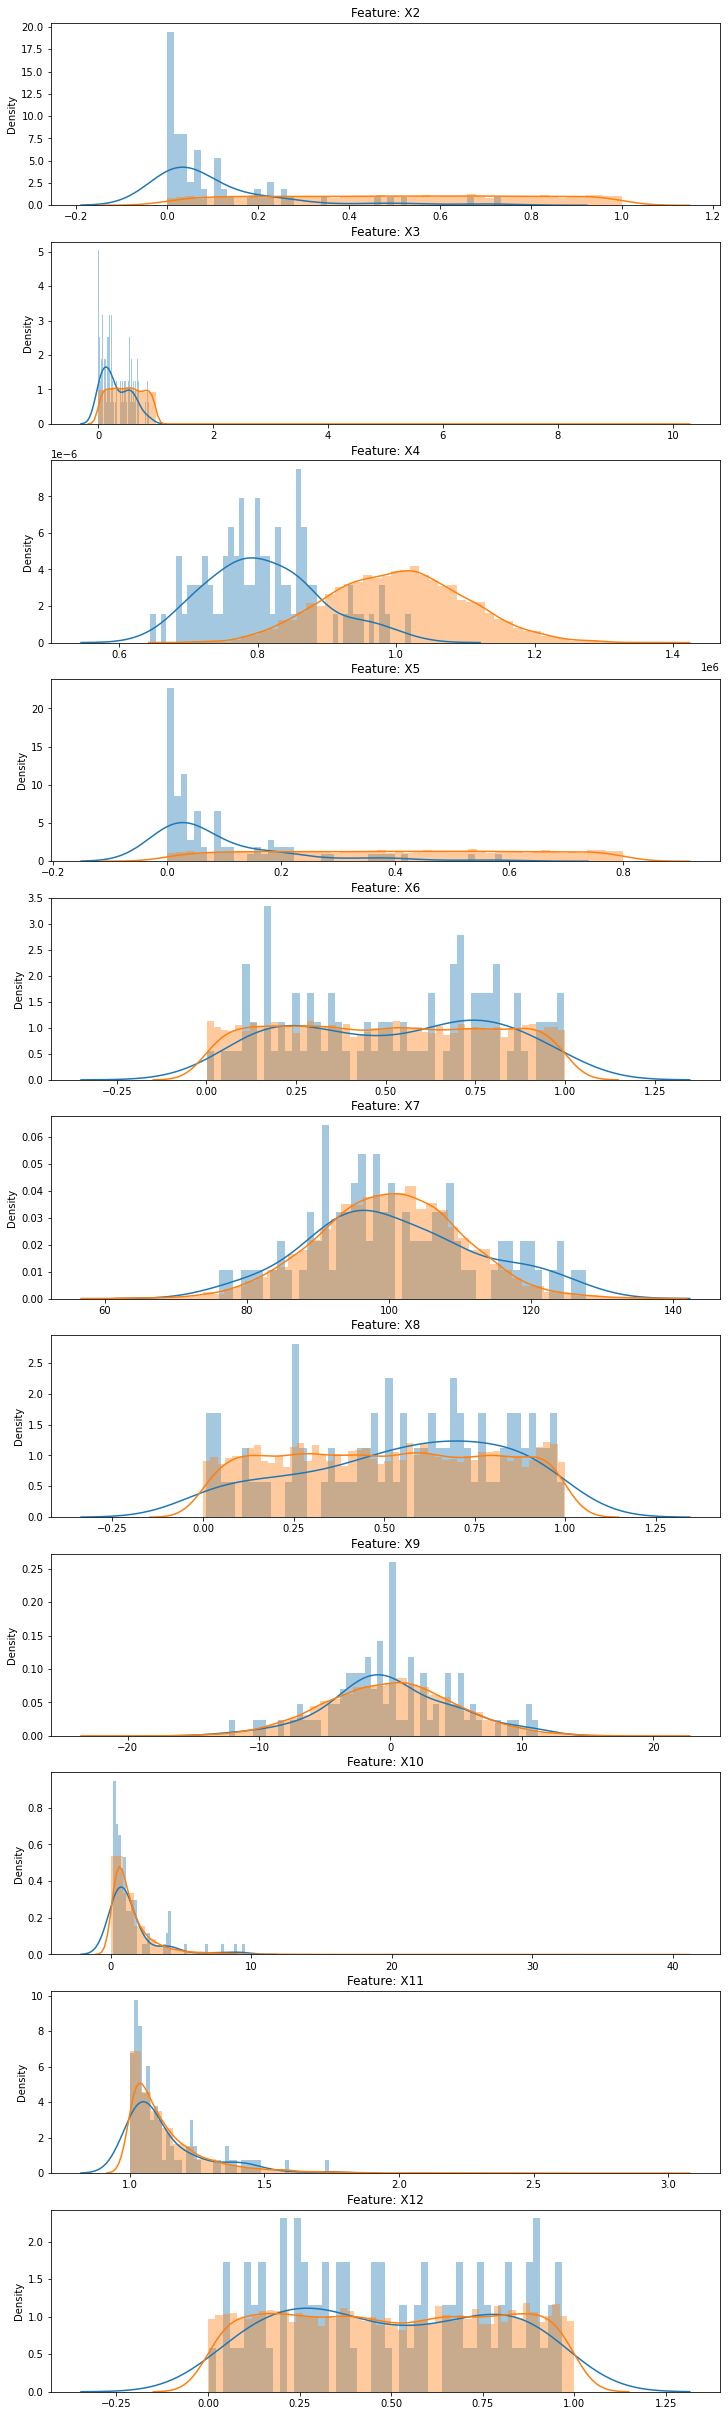

In [25]:
# Creating PDE plots for all the numeric features grouped by class labels.

plt.figure(figsize=(12,30*4))

features = df_train_data.columns[1:12]

gs = gridspec.GridSpec(30, 1)
for i, feature in enumerate(df_train_data[features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df_train_data[feature][df_train_data.Default_Ind == 1], bins=50)
    sns.distplot(df_train_data[feature][df_train_data.Default_Ind == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('Feature: ' + str(feature))
plt.show()

###2. Bivariate Analysis

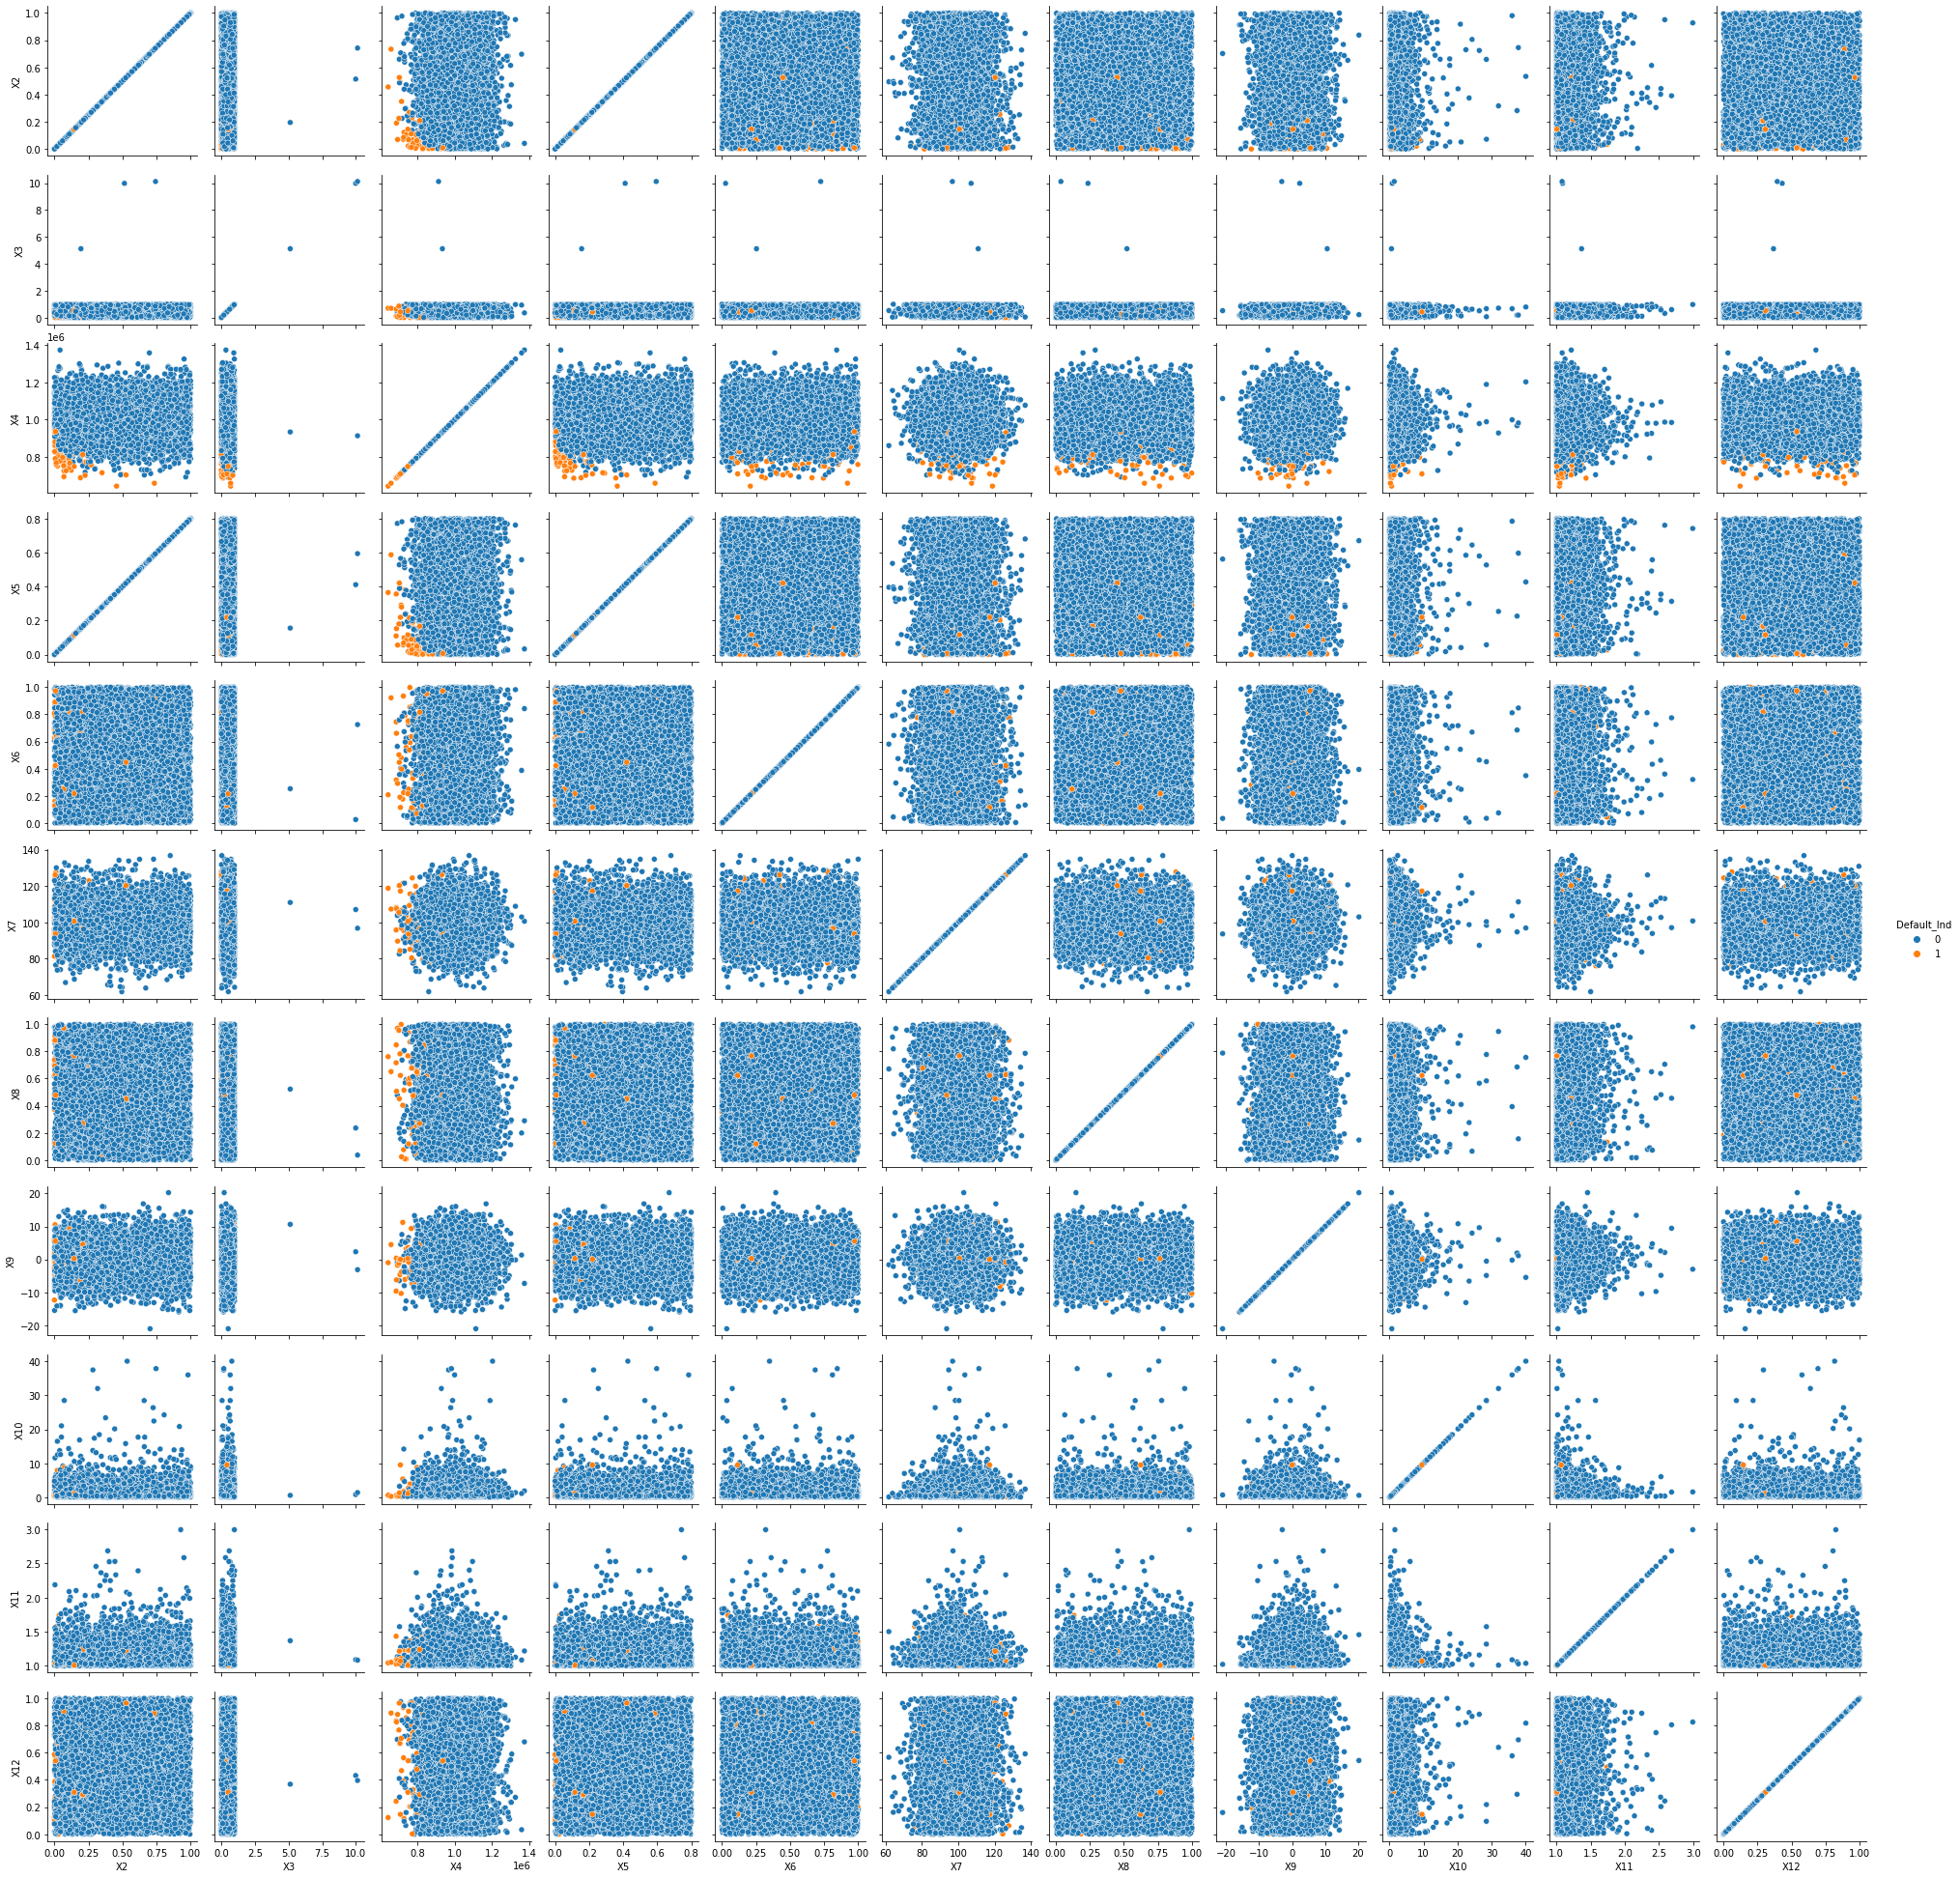

In [28]:
#Creating pair-wise plots for all the numeric features.
sns.pairplot(df_train_data, hue='Default_Ind', diag_kind=None)
plt.show()

####2.1 Correlation Matrix

In [29]:
#Calculationg correlation matrix for all the numeric features alog with the class label.

correlation = df_train_data.corr()
correlation

X2        X3        X4  ...       X11       X12  Default_Ind
X2           1.000000 -0.001556  0.035038  ...  0.003215  0.003883    -0.153830
X3          -0.001556  1.000000 -0.031733  ...  0.001288 -0.017131    -0.062800
X4           0.035038 -0.031733  1.000000  ... -0.019050  0.010130    -0.220178
X5           1.000000 -0.001675  0.036554  ...  0.000105  0.005728    -0.153333
X6          -0.007813 -0.015926 -0.000951  ... -0.019638 -0.006327     0.009938
X7          -0.018689  0.007999 -0.008742  ... -0.003689 -0.013025     0.009991
X8          -0.008846 -0.009876 -0.003916  ...  0.027693  0.000381     0.021184
X9           0.006769 -0.000628  0.014991  ...  0.022781 -0.022109     0.002672
X10          0.001799 -0.004037  0.009282  ...  0.015200  0.011195    -0.006302
X11          0.003215  0.001288 -0.019050  ...  1.000000 -0.020095    -0.008640
X12          0.003883 -0.017131  0.010130  ... -0.020095  1.000000    -0.000015
Default_Ind -0.153830 -0.062800 -0.220178  ... -0.008640 -0.000015     1.000000

[12 rows x 12 columns]

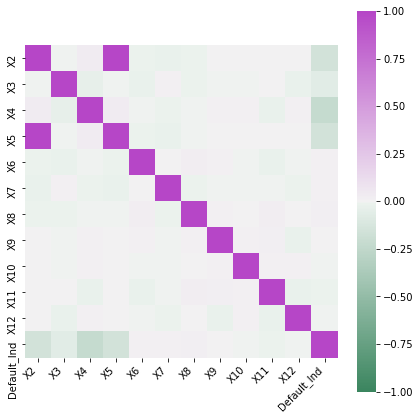

In [30]:
#Visualizing Correlation Matrix.
fig, ax = plt.subplots(1,1, figsize=(7,7))
sns.heatmap(correlation, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(145, 300, as_cmap=True), square=True, ax=ax)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')
plt.show()

####2.2. Statistical Tests (ANOVA and Chi-square)

In [31]:
#Remove Missing values and separating Categorical/Numerical data for statistical tests
df_train_no_missing = df_train_data.dropna()

categorical_features = ((df_train_no_missing.select_dtypes(include='object')).copy()).values
numeric_features = ((df_train_no_missing.select_dtypes(include='float64')).copy()).values
class_labels = (df_train_no_missing.iloc[:,-1]).values

In [32]:
#Encoding Categorical Columns
categorical_features = OrdinalEncoder().fit_transform(categorical_features)

In [33]:
#Applying Chi-square and ANOVA test on Categorical and Numerical data respectively.

num_kbest = SelectKBest(score_func=f_classif, k='all').fit(numeric_features, class_labels)
cat_kbest = SelectKBest(score_func=chi2, k='all').fit(categorical_features, class_labels)

In [34]:
#Scores from Chi-square and ANOVA

num_kbest_scores = list(num_kbest.scores_)
cat_kbest_scores = list(cat_kbest.scores_)

In [37]:
num_features_names = df_train_no_missing.select_dtypes(include='float64').columns.tolist()
cat_features_names = df_train_no_missing.select_dtypes(include='object').columns.tolist()

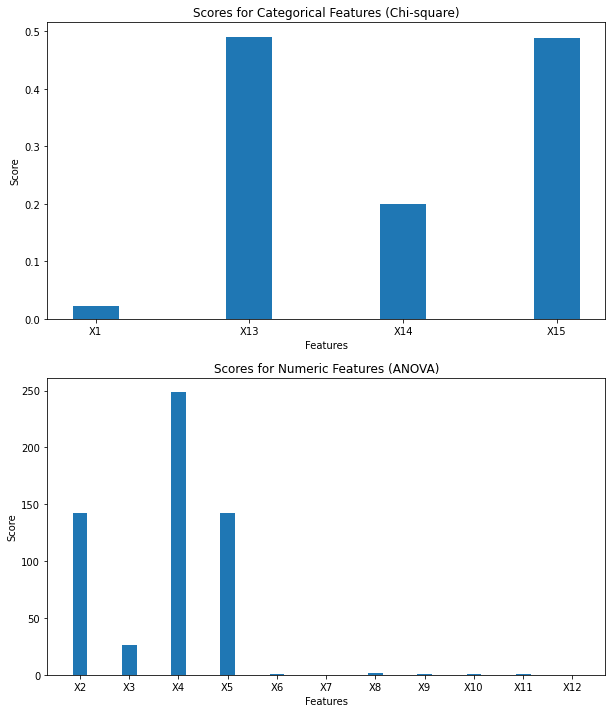

In [38]:
##Plotting the scores

fig,ax = plt.subplots(2,1, figsize=(10,12))

ax[0].bar(cat_features_names, height=cat_kbest_scores, width=0.3)
ax[0].set_title('Scores for Categorical Features (Chi-square)')
ax[0].set_xlabel('Features')
ax[0].set_ylabel('Score')

ax[1].bar(num_features_names, height=num_kbest_scores, width=0.3)
ax[1].set_title('Scores for Numeric Features (ANOVA)')
ax[1].set_xlabel('Features')
ax[1].set_ylabel('Score')

plt.show()

####2.3 Remove unwanted feature columns.

In [39]:
#The best subset of features was selected: [X1,X3,X4,X5,X13,X14,X15]
#This subset was selected using the above statistical information and repetitive experimentation (classification performance).
#X2 and X5 are highly correlated(1.0).
#Also X2 had more missing values.

#Dropping rest of the feature columns
df_train_data = df_train_data.drop(columns=['X2','X6','X7','X8','X9','X10','X11','X12'])
df_test_data = df_test_data.drop(columns=['X2','X6','X7','X8','X9','X10','X11','X12'])

##**Outlier Removal**

In [40]:
#Function to remove outliers from a dataframe based on z-score
#Args: DataFrame, Threshold (z-score) value for filtering out the outliers.
#Return: DataFrame without outliers, Number of Outliers removed.  

from collections import Counter

def remove_outliers(df, z_score_thresh=3):

  df_num = ((df.select_dtypes(include='float64')).copy()).iloc[:,:-1]

  z_scores = np.abs(stats.zscore(df_num, nan_policy='omit'))
  outlier_indices= np.where(z_scores > z_score_thresh)
  num_outliers = outlier_indices[0].shape[0]

  df = df.drop(index=outlier_indices[0])

  print(Counter(outlier_indices[1]))
  return df, num_outliers

In [41]:
#Removing Outliers from the Train set.

df_train_data, num_outliers = remove_outliers(df_train_data, z_score_thresh=3)
print('Number of outliers removed: {}'.format(num_outliers))

Counter({1: 12, 0: 3})
Number of outliers removed: 15


In [42]:
#Class distribution of the Train set after removing outliers.

print('Training set class distribution after outlier removal')
get_class_distribution(df_train_data)

Training set class distribution after outlier removal
Class 0: 6901 | 98.797%
Class 1: 84 | 1.203%


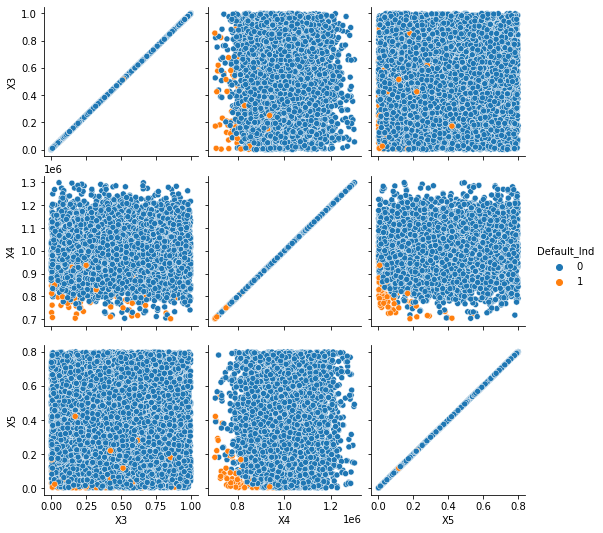

In [43]:
#Pairwise plot to check Train data after removing outliers.

sns.pairplot(df_train_data, hue='Default_Ind', diag_kind=None)
plt.show()

##**Handling Missing Data**

In [44]:
#Number of Missing values in each column of the Train set.

print(df_train_data.isna().sum())

X1               0
X3               0
X4             720
X5               0
X13              0
X14              0
X15              0
Default_Ind      0
dtype: int64


In [45]:
#Number of Missing values in each column of the Train set.

print(df_test_data.isna().sum())

X1               0
X3               0
X4             279
X5               0
X13              0
X14              0
X15              0
Default_Ind      0
dtype: int64


In [46]:
#Dropping rows with missing values from the Train set aand imputing the Test set.

df_train_data = df_train_data.dropna()
df_test_data['X4'].fillna(df_train_data['X4'].mean(), inplace=True)

In [47]:
#Reset row indices of Train set and Test Set after removing missing records.

df_train_data.reset_index(drop=True, inplace=True)
df_test_data.reset_index(drop=True, inplace=True)

In [48]:
print('Training set after removing missing records.')
get_class_distribution(df_train_data)

Training set after removing missing records.
Class 0: 6187 | 98.755%
Class 1: 78 | 1.245%


In [49]:
print('Test set after removing missing records.')
get_class_distribution(df_test_data)

Test set after removing missing records.
Class 0: 2961 | 98.700%
Class 1: 39 | 1.300%


##**Separating Features columns and the Class Label column.**

In [50]:
#X_train_df: DataFrame for Training data features.
#y_train_df: DataFrame for Training data class labels.

y_train_df = df_train_data.iloc[:,-1]
X_train_df = df_train_data.drop(['Default_Ind'], axis=1)
X_train_df.head()

X1        X3            X4        X5 X13   X14  X15
0               C&I  0.795355  1.156189e+06  0.090963   C  T982  Yes
1  CRE Construction  0.821238  1.046683e+06  0.487420   B  T982  Yes
2  CRE Construction  0.613073  1.085325e+06  0.498704   B  T982   No
3  CRE Construction  0.709228  1.051379e+06  0.688732   B  R567  Yes
4               C&I  0.198039  7.965421e+05  0.512248   C  T982  Yes

In [51]:
#X_train_df: DataFrame for Training data features.
#y_train_df: DataFrame for Training data class labels.

X_test_df = df_test_data.drop(['Default_Ind'], axis=1)
y_test_df = df_test_data.iloc[:,-1]
X_test_df.head()

X1        X3            X4        X5 X13   X14  X15
0               C&I  0.401540  9.300082e+05  0.021838   B  Y237   No
1               C&I  0.848459  9.995047e+05  0.543226   A  T982  Yes
2     CRE Permanent  0.633293  9.186776e+05  0.151973   B  T982  Yes
3               C&I  0.688461  1.062604e+06  0.735222   A  X456  Yes
4  CRE Construction  0.405373  9.164936e+05  0.418931   C  Y237  Yes

##**Creating Data Pre-processing pipeline.**

###1. Separating Numerical and Categorical Features. 

In [52]:
#Function to separate numeric and categorical features names from a dataframe:
#Args: DataFrame.
#Returns: Numerical feature names, Categorical features names.

def separate_features(df):
  cat_feature_mask = df.dtypes == object
  cat_features_names = df.columns[cat_feature_mask].tolist()
  num_features_names = df.columns[~cat_feature_mask].tolist()
  return num_features_names, cat_features_names

In [53]:
num_features_names, cat_features_names = separate_features(X_train_df)

In [54]:
print(num_features_names)

['X3', 'X4', 'X5']


In [55]:
print(cat_features_names)

['X1', 'X13', 'X14', 'X15']


###2. Create transformers for Numeric and Categorical features. 

In [56]:
##DataFrame Transformer for Numeric Data (Standardization)

standardize_mapper = DataFrameMapper(
                                    [([num_feature], StandardScaler()) for num_feature in num_features_names],
                                      input_df=True, df_out=True)

In [57]:
##DataFrame Transformer for Categorical Data (One-hot Encoding with dummy variables)

one_hot_encode_mapper = DataFrameMapper(
                                        [([cat_feature], OneHotEncoder(drop='first', dtype='int', sparse=False)) for cat_feature in cat_features_names],
                                            input_df=True, df_out=True)

###3. Feature Union using Numeric and Categorical transformers.

In [58]:
#Uniting Numerical and Categorical Transformers using Feature Union

feature_union = FeatureUnion([
                              ("standardize_mapper", standardize_mapper),
                              ("one_hot_encode_mapper", one_hot_encode_mapper)]) 

In [59]:
feature_union.get_params

<bound method FeatureUnion.get_params of FeatureUnion(n_jobs=None,
             transformer_list=[('standardize_mapper',
                                DataFrameMapper(default=False, df_out=True,
                                                features=[(['X3'],
                                                           StandardScaler(copy=True,
                                                                          with_mean=True,
                                                                          with_std=True)),
                                                          (['X4'],
                                                           StandardScaler(copy=True,
                                                                          with_mean=True,
                                                                          with_std=True)),
                                                          (['X5'],
                                                           StandardSca

##**Create classification pipeline using Data Pre-processing pipeline.**

In [60]:
#Create a classification pipeline using Feature Union and Logistic Regression  Classifier

clf_pipeline = Pipeline([
                     ("feature_union",feature_union),
                     ("clf_lr",LogisticRegression())
])

In [61]:
#Evaluate a simple model without hyper-parameter tuning.

cv_scores = cross_val_score(clf_pipeline, X_train_df, y=y_train_df, cv=5, scoring='average_precision')

In [62]:
#Cross-validation results
print('AUC-PR for 5-folds: {}'.format(cv_scores))
print('Cross Validation Result: Mean= {:.3f} and Std= {:.3f}'.format(cv_scores.mean(), cv_scores.std()))

AUC-PR for 5-folds: [0.69110058 0.88302046 0.86826292 0.84318401 0.90119267]
Cross Validation Result: Mean= 0.837 and Std= 0.076


In [63]:
# Get Transformed features from Feature Union 

X_train = feature_union.fit_transform(X_train_df)
y_train = y_train_df.values

X_test = feature_union.transform(X_test_df)
y_test = y_test_df.values

#Classification Report from Logistic Regression Classifier

clf_lr = LogisticRegression().fit(X_train,y_train)
lr_predictions = clf_lr.predict(X_test)
lr_predictions_prob = clf_lr.predict_proba(X_test)[:,1]
print(classification_report(y_test, lr_predictions, digits=4))
print('AUC-PR: {:.4f}'.format(average_precision_score(y_test, lr_predictions_prob))) 

              precision    recall  f1-score   support

           0     0.9956    0.9993    0.9975      2961
           1     0.9286    0.6667    0.7761        39

    accuracy                         0.9950      3000
   macro avg     0.9621    0.8330    0.8868      3000
weighted avg     0.9948    0.9950    0.9946      3000

AUC-PR: 0.8481


##**XGBoost Classification**

###1. Checking the effect of different hyper-parameters manually using XGB-CV.

In [64]:
#Checking effect of each hyper-parameter on the performance (AUC-PR) manually using XGB-CV

n_folds = 5
early_stopping = 50

params = {'random_state':0,
          'objective': 'binary:logistic',
          'eval_metric':'aucpr',
          'max_depth':3,
          'learning_rate':0.1,
          'colsample_bytree': 1,
          'subsample':0.9,
          'min_child_weight':1,
          'scale_pos_weight':51,
          'gamma': 0.09
          }

# Create the DTrain matrix for XGBoost
DTrain = xgb.DMatrix(X_train, label = y_train)

# Create the data frame of cross validations
cv_df = xgb.cv(params,  DTrain, num_boost_round = 500, nfold=n_folds,
            early_stopping_rounds=early_stopping,  shuffle=True, metrics=['aucpr'])

In [65]:
num_iterations = cv_df.shape[0]
cv_df.tail()

train-aucpr-mean  train-aucpr-std  test-aucpr-mean  test-aucpr-std
197               1.0              0.0         0.946694        0.035050
198               1.0              0.0         0.946694        0.035050
199               1.0              0.0         0.947497        0.035082
200               1.0              0.0         0.946672        0.035969
201               1.0              0.0         0.947783        0.035225

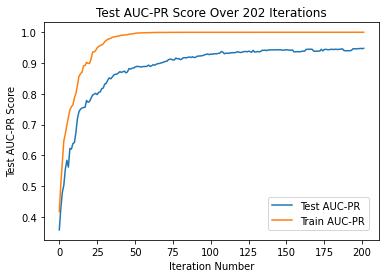

In [66]:
# Plot the test AUC-PR scores for each iteration

plt.plot(cv_df['test-aucpr-mean'], label='Test AUC-PR')
plt.plot(cv_df['train-aucpr-mean'], label='Train AUC-PR')
plt.title('Test AUC-PR Score Over {} Iterations'.format(num_iterations))
plt.xlabel('Iteration Number')
plt.ylabel('Test AUC-PR Score')
plt.legend(bbox_to_anchor=(1,0), loc=4, borderaxespad=1)
plt.show()

###2. Fine-tuning using GridSearchCV

In [67]:
#Create a classification pipeline using Feature Union and XGBoost Classifier

clf_gbt_pipeline = Pipeline([
                     ("feature_union",feature_union),
                     ("clf",xgb.XGBClassifier(objective='binary:logistic', random_state=0))
])

In [ ]:
#Determined the range of values for each hyper-parameter manually in step 1.
#Now applying full-fledged grid search.

params_grid = [
               {
                  'clf__learning_rate':[0.1],
                  'clf__n_estimators':[200,240,270,300],
                  'clf__max_depth':[3,5],
                  'clf__subsample':[0.8,0.9,1],
                  'clf__colsample_bytree':[0.5,0.8,1],
                  'clf__scale_pos_weight':[45,50,55],
                  'clf__gamma': [0,0.05,1,3],
                }
              ]

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid_search = GridSearchCV(estimator=clf_gbt_pipeline,
                           param_grid=params_grid,
                           scoring='average_precision',
                           cv=k_fold,
                           n_jobs=-1,
                           verbose=1)

In [ ]:
grid_result = grid_search.fit(X_train_df, y_train_df)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 42.5min finished


In [ ]:
print('Mean AUC-PR: {:.4f}'.format(grid_result.cv_results_['mean_test_score'][0]))
print('Std AUC-PR: {:.4f}'.format(grid_result.cv_results_['std_test_score'][0]))

Mean AUC-PR: 0.9025
Std AUC-PR: 0.0374


In [ ]:
grid_result.best_params_

{'clf__colsample_bytree': 1,
 'clf__gamma': 1,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 3,
 'clf__n_estimators': 270,
 'clf__scale_pos_weight': 55,
 'clf__subsample': 0.8}

In [ ]:
#Further narrowing down the search space to get better hyper-parameters

params_grid_final = [
               {
                  'clf__learning_rate':[0.1],
                  'clf__n_estimators':[260,270,280],
                  'clf__max_depth':[3],
                  'clf__subsample':[0.9,1],
                  'clf__colsample_bytree':[0.9,1],
                  'clf__scale_pos_weight':[50,51,52],
                  'clf__gamma': [0.09,1,1.02],
                }
              ]


k_fold_final = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid_search_final = GridSearchCV(estimator=clf_gbt_pipeline,
                           param_grid=params_grid_final,
                           scoring='average_precision',
                           cv=k_fold_final,
                           n_jobs=-1,
                           verbose=1)

In [ ]:
grid_result_final = grid_search_final.fit(X_train_df, y_train_df)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  5.2min finished


In [ ]:
print('Mean AUC-PR: {:.4f}'.format(grid_result_final.cv_results_['mean_test_score'][0]))
print('Std AUC-PR: {:.4f}'.format(grid_result_final.cv_results_['std_test_score'][0]))

Mean AUC-PR: 0.9287
Std AUC-PR: 0.0323


In [ ]:
grid_result_final.best_params_

{'clf__colsample_bytree': 0.9,
 'clf__gamma': 0.09,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 3,
 'clf__n_estimators': 280,
 'clf__scale_pos_weight': 52,
 'clf__subsample': 0.9}

##**Performance Evaluation on Test set**

In [68]:
#Function to plot Threshold vs Performance curve and Precison-Recall curve.
#Args: Trained model, Features, True labels, thresholds.
#Return Performance DF (Precision, Recall, F1-score at each threshold) 

def performance_threshold_curve(clf, X, y, thresholds=list(np.arange(start=0.01, stop=1, step=0.01))):

  precision = []
  recall = []
  f1 = []
  y_prob = clf.predict_proba(X)[:,1]

  for threshold in thresholds:
    y_labels = (y_prob >= threshold).astype(np.int)
    p,r,f,s = precision_recall_fscore_support(y, y_labels, average='binary')
    precision.append(p)
    recall.append(r)
    f1.append(f)

  performance_dict = {"Precision":precision,
                      "Recall":recall,
                      "F1-Score":f1,
                      "Threshold":thresholds}

  performance_df = pd.DataFrame(performance_dict, columns=['Precision','Recall','F1-Score','Threshold'])
  avg_pr = average_precision_score(y, y_prob)

  figure,ax = plt.subplots(1,2, figsize=(15,5))
  ax[0].set_title('Threshold vs Performance')
  ax[0].set_xlabel('Threshold')
  ax[0].set_ylabel('Performance')
  ax[0].plot(performance_df['Threshold'], performance_df['Precision'], 'r', label='Precision')
  ax[0].plot(performance_df['Threshold'], performance_df['Recall'], 'g', label='Recall')
  ax[0].plot(performance_df['Threshold'], performance_df['F1-Score'], 'b', label='F1-Score')
  ax[0].legend(bbox_to_anchor=(0.4,0), loc=3, borderaxespad=1)

  pr_plot = plot_precision_recall_curve(clf, X, y, ax=ax[1])
  ax[1].set_title('Precision-Recall curve: AP={:.4f}'.format(avg_pr))

  plt.show()

  return performance_df

In [69]:
#Fit an XGBClassifer with the best hyper-parameters determined from the grid-search.

clf_gbt = xgb.XGBClassifier(n_estimators=280,
                            learning_rate=0.1,
                            max_depth=3,
                            random_state=0,
                            reg_alpha=1,
                            reg_lambda=1,
                            scale_pos_weight=52,
                            colsample_bytree=0.9,
                            subsample=0.9,
                            gamma=0.09,
                            ).fit(X_train, y_train)

In [71]:
#Predicitions on the test set

test_predictions = clf_gbt.predict(X_test)
test_prediction_proba = clf_gbt.predict_proba(X_test)[:,1]

In [72]:
#Classification Report on the Test Set

print(classification_report(y_test, test_predictions, digits=4))
print(confusion_matrix(y_test, test_predictions))

              precision    recall  f1-score   support

           0     0.9993    0.9986    0.9990      2961
           1     0.9024    0.9487    0.9250        39

    accuracy                         0.9980      3000
   macro avg     0.9509    0.9737    0.9620      3000
weighted avg     0.9981    0.9980    0.9980      3000

[[2957    4]
 [   2   37]]


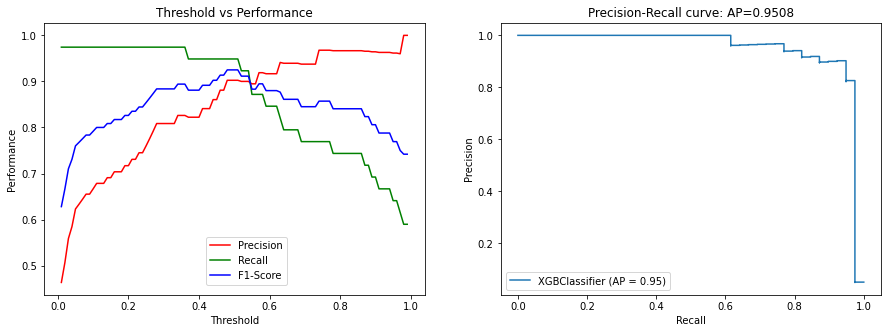



Best Threshold (Highest F1): 0.48
Precision: 0.9024
Recall: 0.9487
F1-Score: 0.9250


In [73]:
#Plotting Performance vs Threshold curve

perf_df = performance_threshold_curve(clf_gbt, X_test, y_test)
best_index = np.argmax(perf_df['F1-Score'])

print('\n')
print("Best Threshold (Highest F1): {:.2f}".format(perf_df['Threshold'].iloc[best_index]))
print("Precision: {:.4f}".format(perf_df['Precision'].iloc[best_index]))
print("Recall: {:.4f}".format(perf_df['Recall'].iloc[best_index]))
print("F1-Score: {:.4f}".format(perf_df['F1-Score'].iloc[best_index]))

In [74]:
#Feature importance of each feature obtained from the trained model.

feature_names = ['X3','X4','X5','X1-CRE Const','X1-CRE Perm','X13-B','X13-A','X14-1','X14-2','X14-3','X14-4','X15']
feature_importance = sorted(zip(feature_names, list(clf_gbt.feature_importances_)), key= lambda x:x[1])
feature_imp_names = [f_i[0] for f_i in feature_importance]
print(*feature_importance, sep='\n')

('X15', 0.0022303935)
('X14-4', 0.0026416345)
('X14-2', 0.0031443168)
('X1-CRE Perm', 0.0032891023)
('X13-B', 0.0035301282)
('X1-CRE Const', 0.0036617445)
('X13-A', 0.004392564)
('X14-3', 0.0055472455)
('X14-1', 0.005647723)
('X3', 0.039938033)
('X5', 0.31711304)
('X4', 0.60886407)


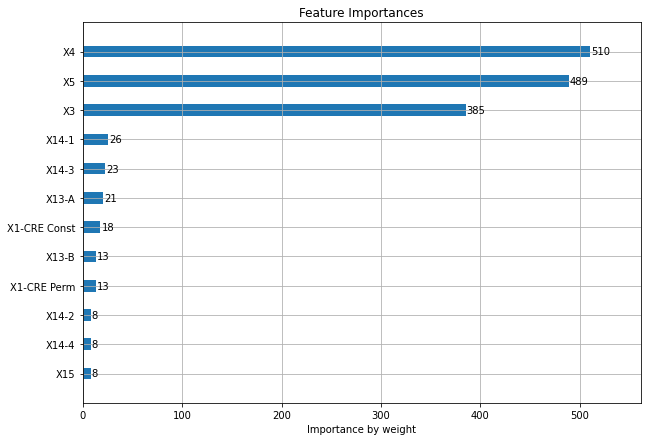

In [75]:
#Plot feature importance.

fig, ax = plt.subplots(1,1, figsize=(10,7))
xgb.plot_importance(clf_gbt, ax=ax, height=0.4)
ax.set_title('Feature Importances')
ax.set_xlabel('Importance by weight')
ax.set_ylabel("")
ax.set_yticklabels(feature_imp_names)
plt.show()

##**Results Summary**


In [76]:
results_dict = {
                "Classifiers":['Logistic Regression','XGBoost'],
                "Recall":['83.30','97.37'],
                "Precision":['96.21','95.09'],
                "F-1 Score":['88.68','96.20'],
                "AUC-PR":['84.81','95.08']
                }

In [77]:
results_df = pd.DataFrame(results_dict, index=["Baseline","Final"])
results_df

Classifiers Recall Precision F-1 Score AUC-PR
Baseline  Logistic Regression  83.30     96.21     88.68  84.81
Final                 XGBoost  97.37     95.09     96.20  95.08